In [102]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
import networkx as nx
import scipy
import json
import sys
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
#sys.path.append('/content/drive/MyDrive/EcolesIngenieur/NTNU/MachineLearning/GroupWork/')
import utils
#import settings


plt.style.use('fivethirtyeight')
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [103]:
from sklearn.preprocessing import StandardScaler
import pickle #pour charger un scaler déjà entrainé

In [104]:
train_a, train_b, train_c, X_train_estimated_a, X_train_estimated_b, X_train_estimated_c, X_train_observed_a, X_train_observed_b, X_train_observed_c, X_test_estimated_a, X_test_estimated_b, X_test_estimated_c = utils.read_files(diff_path='')

In [133]:
X_train_estimated_a.describe()['date_forecast'], X_train_observed_a.describe()

(count                         17576
 mean     2023-01-28 23:11:50.127446
 min             2022-10-28 22:00:00
 25%             2022-12-13 16:26:15
 50%             2023-01-29 10:52:30
 75%             2023-03-16 05:18:45
 max             2023-04-30 23:45:00
 std                             NaN
 Name: date_forecast, dtype: object,
              date_forecast  absolute_humidity_2m:gm3  air_density_2m:kgm3  \
 count                29666              29666.000000         29666.000000   
 mean   2021-02-09 22:30:00                  0.000020            -0.000039   
 min    2019-06-02 22:00:00                 -2.127325            -2.863315   
 25%    2020-04-06 22:15:00                 -0.805028            -0.689647   
 50%    2021-02-09 22:30:00                 -0.126010            -0.056807   
 75%    2021-12-15 22:45:00                  0.695958             0.631062   
 max    2022-10-20 23:00:00                  3.876619             4.895857   
 std                    NaN                

In [105]:
X_train_observed_a.describe()['date_forecast'], X_train_observed_b.describe()['date_forecast'], X_train_observed_c.describe()['date_forecast']

(count                 118669
 mean     2021-02-09 23:30:00
 min      2019-06-02 22:00:00
 25%      2020-04-06 22:45:00
 50%      2021-02-09 23:30:00
 75%      2021-12-16 00:15:00
 max      2022-10-21 01:00:00
 std                      NaN
 Name: date_forecast, dtype: object,
 count                 116929
 mean     2020-09-01 00:00:00
 min      2019-01-01 00:00:00
 25%      2019-11-01 12:00:00
 50%      2020-09-01 00:00:00
 75%      2021-07-02 12:00:00
 max      2022-05-03 00:00:00
 std                      NaN
 Name: date_forecast, dtype: object,
 count                 116825
 mean     2020-08-31 11:00:00
 min      2019-01-01 00:00:00
 25%      2019-11-01 05:30:00
 50%      2020-08-31 11:00:00
 75%      2021-07-01 16:30:00
 max      2022-05-01 22:00:00
 std                      NaN
 Name: date_forecast, dtype: object)

In [106]:
def normalize_df(df, keys, time_column):
    df_normalized = df.copy()
    columns_to_drop = [ c for c in df_normalized.columns if (c not in keys) and (c != time_column) ]
    df_normalized = df_normalized.drop(columns=columns_to_drop)
    for key in keys :
        if key in time_column:
            continue
        else: 
            if df[key].std() == .0:
                columns_to_drop.append(key)
                df_normalized.drop(columns=key)
            else:
                df_normalized[key] = (df[key] - df[key].mean()) / df[key].std()
    df_normalized.drop(columns=columns_to_drop)
    return df_normalized

In [107]:
import models_arthur.signal_process as s
from datetime import datetime, timedelta

locations = ['a', 'b', 'c']
hours = [ f"0{h}" if h < 10 else str(h) for h in range(24) ]

basic_params = {
    'diff_path': ''
}
params = { 'a': {
        'location': 'a',
        'start_date': datetime(2019,6,2, 0, 0, 0), 
        'end_date': datetime(2022, 10, 21, 0, 0, 0),
        'split_date': datetime(2022, 7, 21),
        # 'split_date': pd.to_datetime("2022-07-21"),
        **basic_params
    },
    'b': {
        'location': 'b',
        'start_date': datetime(2019, 1, 1, 0, 0, 0), 
        'end_date': datetime(2022, 5, 3, 0, 0, 0), 
        'split_date': datetime(2022, 2, 3),
        # 'split_date': pd.to_datetime("2021-12-15"),
        **basic_params
    },
    'c': {
        'location': 'c',
        'start_date': datetime(2019, 1, 1, 0, 0, 0),
        'end_date': datetime(2022, 5, 1, 0, 0, 0),
        'split_date': datetime(2022, 3, 1),
        # 'split_date': pd.to_datetime("2022-01-01"),
        **basic_params
    },
}

In [108]:
s_ = { loc: s.SignalProcess(**params[loc]) for loc in locations }
y_train = { loc: s_[loc].train_normalized for loc in locations }
y_test = { loc: s_[loc].test_normalized for loc in locations }

In [109]:
train_a.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge
train_b.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge
train_c.rename(columns={'time': 'date_forecast'}, inplace=True) #pour faire le merge

train_a.dropna(subset=['pv_measurement'], inplace=True)  #Supprime les lignes vides
train_b.dropna(subset=['pv_measurement'], inplace=True)  #Supprime les lignes vides
train_c.dropna(subset=['pv_measurement'], inplace=True)  #Supprime les lignes vides

In [110]:
X_train_observed_a = pd.merge(X_train_observed_a, train_a, on='date_forecast', how='inner').dropna(subset='pv_measurement').drop(columns='pv_measurement')
X_train_observed_b = pd.merge(X_train_observed_b, train_b, on='date_forecast', how='inner').dropna(subset='pv_measurement').drop(columns='pv_measurement')
X_train_observed_c = pd.merge(X_train_observed_c, train_c, on='date_forecast', how='inner').dropna(subset='pv_measurement').drop(columns='pv_measurement')

In [111]:
from normalization import normalize_list_df, unnorm_df

list_df = [ X_train_estimated_a, X_train_estimated_b, X_train_estimated_c, X_train_observed_a, X_train_observed_b, X_train_observed_c, X_test_estimated_a, X_test_estimated_b, X_test_estimated_c]
dfs, means, stds = normalize_list_df(list_df)
X_train_estimated_a, X_train_estimated_b, X_train_estimated_c, X_train_observed_a, X_train_observed_b, X_train_observed_c, X_test_estimated_a, X_test_estimated_b, X_test_estimated_c = dfs

In [112]:
X_train_observed_a = X_train_observed_a[(X_train_observed_a['date_forecast'] >= params['a']['start_date']) & (X_train_observed_a['date_forecast'] < params['a']['end_date'])]
X_train_observed_b = X_train_observed_b[(X_train_observed_b['date_forecast'] >= params['b']['start_date']) & (X_train_observed_b['date_forecast'] < params['b']['end_date'])]
X_train_observed_c = X_train_observed_c[(X_train_observed_c['date_forecast'] >= params['c']['start_date']) & (X_train_observed_c['date_forecast'] < params['c']['end_date'])]

In [113]:
X_tr_obs_a = { h: X_train_observed_a[X_train_observed_a['date_forecast'].dt.strftime('%H:%M:%S').str.endswith(f'{h}:00:00')] for h in hours }
X_tr_obs_b = { h: X_train_observed_b[X_train_observed_b['date_forecast'].dt.strftime('%H:%M:%S').str.endswith(f'{h}:00:00')] for h in hours }
X_tr_obs_c = { h: X_train_observed_c[X_train_observed_c['date_forecast'].dt.strftime('%H:%M:%S').str.endswith(f'{h}:00:00')] for h in hours }

print(X_tr_obs_b['00']) 

X_train_a = { h: X_tr_obs_a[h][X_tr_obs_a[h]['date_forecast'] < params['a']['split_date']] for h in hours }
X_train_b = { h: X_tr_obs_b[h][X_tr_obs_b[h]['date_forecast'] < params['b']['split_date']] for h in hours }
X_train_c = { h: X_tr_obs_c[h][X_tr_obs_c[h]['date_forecast'] < params['c']['split_date']] for h in hours }

X_test_a = { h: X_tr_obs_a[h][X_tr_obs_a[h]['date_forecast'] >= params['a']['split_date']] for h in hours }
X_test_b = { h: X_tr_obs_b[h][X_tr_obs_b[h]['date_forecast'] >= params['b']['split_date']] for h in hours }
X_test_c = { h: X_tr_obs_c[h][X_tr_obs_c[h]['date_forecast'] >= params['c']['split_date']] for h in hours }

      date_forecast  absolute_humidity_2m:gm3  air_density_2m:kgm3  \
0        2019-01-01                 -0.192839            -0.432045   
24       2019-01-02                 -0.852163             1.238681   
48       2019-01-03                  0.100194             0.927189   
72       2019-01-04                  0.393227             0.360842   
96       2019-01-05                  0.539744             0.247573   
...             ...                       ...                  ...   
29100    2022-04-28                 -0.266097             0.757287   
29124    2022-04-29                 -0.412614             1.210366   
29148    2022-04-30                 -0.339355             1.012141   
29172    2022-05-01                 -0.009693             0.644015   
29196    2022-05-02                 -0.302726            -0.092234   

       ceiling_height_agl:m  clear_sky_energy_1h:J  clear_sky_rad:W  \
0                 -0.573788              -0.645591        -0.643951   
24               

In [114]:
X_tr_obs_a = { h: normalize_df(X_tr_obs_a[h], X_tr_obs_a[h].columns, 'date_forecast') for h in hours }
X_tr_obs_b = { h: normalize_df(X_tr_obs_b[h], X_tr_obs_b[h].columns, 'date_forecast') for h in hours }
X_tr_obs_c = { h: normalize_df(X_tr_obs_c[h], X_tr_obs_c[h].columns, 'date_forecast') for h in hours }

In [115]:
h = '00'
dates = s_['b'].train_dates[s_['b'].train_dates.dt.strftime('%H:%M:%S').str.endswith(f'{h}:00:00')]
dates

0       2019-01-01
24      2019-01-02
48      2019-01-03
72      2019-01-04
96      2019-01-05
           ...    
29100   2022-04-28
29124   2022-04-29
29148   2022-04-30
29172   2022-05-01
29196   2022-05-02
Name: time, Length: 1211, dtype: datetime64[us]

In [116]:
#function to apply XGBoost model
def create_features(df, label=None):
    """
    Creates time series features including datetime and additional columns from the original DataFrame
    """
    # Add additional columns to X
    additional_columns = [
        'absolute_humidity_2m:gm3', 'air_density_2m:kgm3', 'clear_sky_energy_1h:J',
        'clear_sky_rad:W', 'dew_or_rime:idx', 'dew_point_2m:K', 'diffuse_rad:W',
        'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J', 'effective_cloud_cover:p',
        'elevation:m', 'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm',
        'fresh_snow_3h:cm', 'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
        'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx', 'pressure_100m:hPa',
        'pressure_50m:hPa', 'prob_rime:p', 'rain_water:kgm2', 'relative_humidity_1000hPa:p',
        'sfc_pressure:hPa', 'snow_depth:cm', 'snow_drift:idx', 'snow_melt_10min:mm',
        'snow_water:kgm2', 'sun_azimuth:d', 'sun_elevation:d', 'super_cooled_liquid_water:kgm2',
        't_1000hPa:K', 'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
        'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms', 'wind_speed_w_1000hPa:ms'
    ]
    
    X = df[additional_columns]
    
    if label:
        y = df[label]
        return X, y
    return X

In [117]:
X_train_a = { h: create_features(X_train_a[h]) for h in hours }
X_test_a = { h: create_features(X_test_a[h]) for h in hours }

X_train_b = { h: create_features(X_train_b[h]) for h in hours }
X_test_b = { h: create_features(X_test_b[h]) for h in hours }

X_train_c = { h: create_features(X_train_c[h]) for h in hours }
X_test_c = { h: create_features(X_test_c[h]) for h in hours }

In [118]:
reg_a = {}
for h in hours: 
    reg_a[h] = xgb.XGBRegressor(n_estimators=10000)
    reg_a[h].fit(X_train_a[h], y_train['a'][h],
          eval_set=[(X_train_a[h], y_train['a'][h]), (X_test_a[h], y_test['a'][h])],
          early_stopping_rounds=50,
          verbose=True) 

[0]	validation_0-rmse:0.88330	validation_1-rmse:0.02556
[1]	validation_0-rmse:0.75071	validation_1-rmse:0.01790
[2]	validation_0-rmse:0.63804	validation_1-rmse:0.01253
[3]	validation_0-rmse:0.54230	validation_1-rmse:0.00878
[4]	validation_0-rmse:0.46094	validation_1-rmse:0.00615
[5]	validation_0-rmse:0.39179	validation_1-rmse:0.00430
[6]	validation_0-rmse:0.33301	validation_1-rmse:0.00301
[7]	validation_0-rmse:0.28306	validation_1-rmse:0.00211
[8]	validation_0-rmse:0.24060	validation_1-rmse:0.00148
[9]	validation_0-rmse:0.20451	validation_1-rmse:0.00104
[10]	validation_0-rmse:0.17383	validation_1-rmse:0.00072
[11]	validation_0-rmse:0.14775	validation_1-rmse:0.00051
[12]	validation_0-rmse:0.12559	validation_1-rmse:0.00036
[13]	validation_0-rmse:0.10675	validation_1-rmse:0.00025
[14]	validation_0-rmse:0.09074	validation_1-rmse:0.00017
[15]	validation_0-rmse:0.07713	validation_1-rmse:0.00012
[16]	validation_0-rmse:0.06556	validation_1-rmse:0.00009
[17]	validation_0-rmse:0.05573	validation

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[32]	validation_0-rmse:0.02079	validation_1-rmse:0.02627
[33]	validation_0-rmse:0.01924	validation_1-rmse:0.02661
[34]	validation_0-rmse:0.01761	validation_1-rmse:0.02755
[35]	validation_0-rmse:0.01615	validation_1-rmse:0.02767
[36]	validation_0-rmse:0.01463	validation_1-rmse:0.02768
[37]	validation_0-rmse:0.01345	validation_1-rmse:0.02811
[38]	validation_0-rmse:0.01267	validation_1-rmse:0.02824
[39]	validation_0-rmse:0.01161	validation_1-rmse:0.02827
[40]	validation_0-rmse:0.01112	validation_1-rmse:0.02825
[41]	validation_0-rmse:0.01082	validation_1-rmse:0.02822
[42]	validation_0-rmse:0.01006	validation_1-rmse:0.02820
[43]	validation_0-rmse:0.00967	validation_1-rmse:0.02827
[44]	validation_0-rmse:0.00874	validation_1-rmse:0.02837
[45]	validation_0-rmse:0.00822	validation_1-rmse:0.02830
[46]	validation_0-rmse:0.00770	validation_1-rmse:0.02832
[47]	validation_0-rmse:0.00729	validation_1-rmse:0.02832
[48]	validation_0-rmse:0.00685	validation_1-rmse:0.02827
[49]	validation_0-rmse:0.00642	

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[47]	validation_0-rmse:0.01826	validation_1-rmse:0.31524
[48]	validation_0-rmse:0.01800	validation_1-rmse:0.31522
[49]	validation_0-rmse:0.01778	validation_1-rmse:0.31526
[50]	validation_0-rmse:0.01658	validation_1-rmse:0.31468
[51]	validation_0-rmse:0.01605	validation_1-rmse:0.31464
[52]	validation_0-rmse:0.01548	validation_1-rmse:0.31446
[53]	validation_0-rmse:0.01444	validation_1-rmse:0.31498
[0]	validation_0-rmse:0.75665	validation_1-rmse:0.43322
[1]	validation_0-rmse:0.56960	validation_1-rmse:0.35190
[2]	validation_0-rmse:0.44510	validation_1-rmse:0.31227
[3]	validation_0-rmse:0.35210	validation_1-rmse:0.29913
[4]	validation_0-rmse:0.28822	validation_1-rmse:0.28773
[5]	validation_0-rmse:0.24039	validation_1-rmse:0.29426
[6]	validation_0-rmse:0.20254	validation_1-rmse:0.29369
[7]	validation_0-rmse:0.17958	validation_1-rmse:0.28893
[8]	validation_0-rmse:0.16238	validation_1-rmse:0.29113
[9]	validation_0-rmse:0.14859	validation_1-rmse:0.30042
[10]	validation_0-rmse:0.13890	validation

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[31]	validation_0-rmse:0.06602	validation_1-rmse:0.48109
[32]	validation_0-rmse:0.06351	validation_1-rmse:0.47979
[33]	validation_0-rmse:0.06022	validation_1-rmse:0.48026
[34]	validation_0-rmse:0.05640	validation_1-rmse:0.47995
[35]	validation_0-rmse:0.05447	validation_1-rmse:0.48044
[36]	validation_0-rmse:0.05260	validation_1-rmse:0.48035
[37]	validation_0-rmse:0.05054	validation_1-rmse:0.47939
[38]	validation_0-rmse:0.04963	validation_1-rmse:0.47952
[39]	validation_0-rmse:0.04774	validation_1-rmse:0.47933
[40]	validation_0-rmse:0.04643	validation_1-rmse:0.47945
[41]	validation_0-rmse:0.04527	validation_1-rmse:0.47999
[42]	validation_0-rmse:0.04276	validation_1-rmse:0.47996
[43]	validation_0-rmse:0.04176	validation_1-rmse:0.48048
[44]	validation_0-rmse:0.03975	validation_1-rmse:0.47997
[45]	validation_0-rmse:0.03903	validation_1-rmse:0.48002
[46]	validation_0-rmse:0.03814	validation_1-rmse:0.48050
[47]	validation_0-rmse:0.03722	validation_1-rmse:0.48042
[48]	validation_0-rmse:0.03609	

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[34]	validation_0-rmse:0.09202	validation_1-rmse:0.58015
[35]	validation_0-rmse:0.08781	validation_1-rmse:0.57989
[36]	validation_0-rmse:0.08484	validation_1-rmse:0.58248
[37]	validation_0-rmse:0.08253	validation_1-rmse:0.58166
[38]	validation_0-rmse:0.07958	validation_1-rmse:0.58087
[39]	validation_0-rmse:0.07829	validation_1-rmse:0.58132
[40]	validation_0-rmse:0.07475	validation_1-rmse:0.58120
[41]	validation_0-rmse:0.07329	validation_1-rmse:0.58034
[42]	validation_0-rmse:0.06943	validation_1-rmse:0.58236
[43]	validation_0-rmse:0.06814	validation_1-rmse:0.58148
[44]	validation_0-rmse:0.06567	validation_1-rmse:0.58264
[45]	validation_0-rmse:0.06308	validation_1-rmse:0.58281
[46]	validation_0-rmse:0.05965	validation_1-rmse:0.58206
[47]	validation_0-rmse:0.05793	validation_1-rmse:0.58229
[48]	validation_0-rmse:0.05557	validation_1-rmse:0.58185
[49]	validation_0-rmse:0.05375	validation_1-rmse:0.58161
[50]	validation_0-rmse:0.05061	validation_1-rmse:0.58191
[51]	validation_0-rmse:0.04953	

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[46]	validation_0-rmse:0.06441	validation_1-rmse:0.60759
[47]	validation_0-rmse:0.06283	validation_1-rmse:0.60768
[48]	validation_0-rmse:0.06247	validation_1-rmse:0.60749
[49]	validation_0-rmse:0.06065	validation_1-rmse:0.60928
[50]	validation_0-rmse:0.05901	validation_1-rmse:0.60966
[51]	validation_0-rmse:0.05782	validation_1-rmse:0.60939
[52]	validation_0-rmse:0.05583	validation_1-rmse:0.61013
[53]	validation_0-rmse:0.05387	validation_1-rmse:0.61141
[54]	validation_0-rmse:0.05302	validation_1-rmse:0.61139
[55]	validation_0-rmse:0.05126	validation_1-rmse:0.61155
[56]	validation_0-rmse:0.05075	validation_1-rmse:0.61124
[57]	validation_0-rmse:0.04944	validation_1-rmse:0.61262
[58]	validation_0-rmse:0.04791	validation_1-rmse:0.61227
[0]	validation_0-rmse:0.76983	validation_1-rmse:0.80403
[1]	validation_0-rmse:0.61106	validation_1-rmse:0.68387
[2]	validation_0-rmse:0.50520	validation_1-rmse:0.63190
[3]	validation_0-rmse:0.43532	validation_1-rmse:0.59246
[4]	validation_0-rmse:0.37876	valid

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[38]	validation_0-rmse:0.12204	validation_1-rmse:0.58178
[39]	validation_0-rmse:0.11980	validation_1-rmse:0.58265
[40]	validation_0-rmse:0.11567	validation_1-rmse:0.58342
[41]	validation_0-rmse:0.11401	validation_1-rmse:0.58293
[42]	validation_0-rmse:0.11228	validation_1-rmse:0.58147
[43]	validation_0-rmse:0.11121	validation_1-rmse:0.58164
[44]	validation_0-rmse:0.10852	validation_1-rmse:0.58133
[45]	validation_0-rmse:0.10585	validation_1-rmse:0.57884
[46]	validation_0-rmse:0.10531	validation_1-rmse:0.57926
[47]	validation_0-rmse:0.10167	validation_1-rmse:0.58069
[48]	validation_0-rmse:0.09894	validation_1-rmse:0.58346
[49]	validation_0-rmse:0.09743	validation_1-rmse:0.58469
[50]	validation_0-rmse:0.09658	validation_1-rmse:0.58504
[51]	validation_0-rmse:0.09508	validation_1-rmse:0.58470
[52]	validation_0-rmse:0.08986	validation_1-rmse:0.58662
[53]	validation_0-rmse:0.08607	validation_1-rmse:0.58854
[54]	validation_0-rmse:0.08525	validation_1-rmse:0.58881
[55]	validation_0-rmse:0.08242	

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[40]	validation_0-rmse:0.08678	validation_1-rmse:0.50435
[41]	validation_0-rmse:0.08576	validation_1-rmse:0.50526
[42]	validation_0-rmse:0.08436	validation_1-rmse:0.50483
[43]	validation_0-rmse:0.08145	validation_1-rmse:0.50296
[44]	validation_0-rmse:0.07969	validation_1-rmse:0.50197
[45]	validation_0-rmse:0.07582	validation_1-rmse:0.50296
[46]	validation_0-rmse:0.07391	validation_1-rmse:0.50333
[47]	validation_0-rmse:0.07159	validation_1-rmse:0.50282
[48]	validation_0-rmse:0.07073	validation_1-rmse:0.50340
[49]	validation_0-rmse:0.07024	validation_1-rmse:0.50337
[50]	validation_0-rmse:0.06928	validation_1-rmse:0.50368
[51]	validation_0-rmse:0.06522	validation_1-rmse:0.50406
[52]	validation_0-rmse:0.06385	validation_1-rmse:0.50406
[53]	validation_0-rmse:0.06235	validation_1-rmse:0.50464
[54]	validation_0-rmse:0.06203	validation_1-rmse:0.50476
[55]	validation_0-rmse:0.05917	validation_1-rmse:0.50390
[56]	validation_0-rmse:0.05846	validation_1-rmse:0.50431
[57]	validation_0-rmse:0.05572	

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[41]	validation_0-rmse:0.07610	validation_1-rmse:0.50733
[42]	validation_0-rmse:0.07380	validation_1-rmse:0.50748
[43]	validation_0-rmse:0.07268	validation_1-rmse:0.50697
[44]	validation_0-rmse:0.07214	validation_1-rmse:0.50702
[45]	validation_0-rmse:0.07152	validation_1-rmse:0.50734
[46]	validation_0-rmse:0.07062	validation_1-rmse:0.50743
[47]	validation_0-rmse:0.06839	validation_1-rmse:0.50695
[48]	validation_0-rmse:0.06581	validation_1-rmse:0.50589
[49]	validation_0-rmse:0.06399	validation_1-rmse:0.50610
[50]	validation_0-rmse:0.06180	validation_1-rmse:0.50672
[51]	validation_0-rmse:0.05934	validation_1-rmse:0.50808
[52]	validation_0-rmse:0.05677	validation_1-rmse:0.50943
[53]	validation_0-rmse:0.05580	validation_1-rmse:0.51000
[54]	validation_0-rmse:0.05453	validation_1-rmse:0.51063
[55]	validation_0-rmse:0.05410	validation_1-rmse:0.51005
[56]	validation_0-rmse:0.05367	validation_1-rmse:0.51029
[57]	validation_0-rmse:0.05199	validation_1-rmse:0.51070
[58]	validation_0-rmse:0.04947	

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22]	validation_0-rmse:0.09573	validation_1-rmse:0.47057
[23]	validation_0-rmse:0.09277	validation_1-rmse:0.46831
[24]	validation_0-rmse:0.09223	validation_1-rmse:0.46751
[25]	validation_0-rmse:0.08649	validation_1-rmse:0.46817
[26]	validation_0-rmse:0.08543	validation_1-rmse:0.46816
[27]	validation_0-rmse:0.08306	validation_1-rmse:0.46753
[28]	validation_0-rmse:0.08213	validation_1-rmse:0.46753
[29]	validation_0-rmse:0.07863	validation_1-rmse:0.46804
[30]	validation_0-rmse:0.07334	validation_1-rmse:0.47193
[31]	validation_0-rmse:0.07000	validation_1-rmse:0.47118
[32]	validation_0-rmse:0.06786	validation_1-rmse:0.47071
[33]	validation_0-rmse:0.06684	validation_1-rmse:0.47067
[34]	validation_0-rmse:0.06522	validation_1-rmse:0.47127
[35]	validation_0-rmse:0.06399	validation_1-rmse:0.47205
[36]	validation_0-rmse:0.06272	validation_1-rmse:0.47229
[37]	validation_0-rmse:0.06160	validation_1-rmse:0.47260
[38]	validation_0-rmse:0.05740	validation_1-rmse:0.47272
[39]	validation_0-rmse:0.05596	

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[29]	validation_0-rmse:0.05982	validation_1-rmse:0.28473
[30]	validation_0-rmse:0.05586	validation_1-rmse:0.28540
[31]	validation_0-rmse:0.05160	validation_1-rmse:0.28505
[32]	validation_0-rmse:0.04893	validation_1-rmse:0.28462
[33]	validation_0-rmse:0.04656	validation_1-rmse:0.28474
[34]	validation_0-rmse:0.04243	validation_1-rmse:0.28472
[35]	validation_0-rmse:0.04152	validation_1-rmse:0.28624
[36]	validation_0-rmse:0.03833	validation_1-rmse:0.28625
[37]	validation_0-rmse:0.03712	validation_1-rmse:0.28626
[38]	validation_0-rmse:0.03627	validation_1-rmse:0.28623
[39]	validation_0-rmse:0.03345	validation_1-rmse:0.28621
[40]	validation_0-rmse:0.03106	validation_1-rmse:0.28663
[41]	validation_0-rmse:0.03043	validation_1-rmse:0.28659
[42]	validation_0-rmse:0.02916	validation_1-rmse:0.28623
[43]	validation_0-rmse:0.02777	validation_1-rmse:0.28713
[44]	validation_0-rmse:0.02649	validation_1-rmse:0.28752
[45]	validation_0-rmse:0.02584	validation_1-rmse:0.28856
[46]	validation_0-rmse:0.02503	

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[53]	validation_0-rmse:0.00679	validation_1-rmse:0.16467
[54]	validation_0-rmse:0.00631	validation_1-rmse:0.16470
[55]	validation_0-rmse:0.00588	validation_1-rmse:0.16440
[56]	validation_0-rmse:0.00555	validation_1-rmse:0.16438
[57]	validation_0-rmse:0.00542	validation_1-rmse:0.16442
[58]	validation_0-rmse:0.00529	validation_1-rmse:0.16436
[59]	validation_0-rmse:0.00508	validation_1-rmse:0.16436
[60]	validation_0-rmse:0.00498	validation_1-rmse:0.16433
[61]	validation_0-rmse:0.00463	validation_1-rmse:0.16425
[62]	validation_0-rmse:0.00434	validation_1-rmse:0.16428
[63]	validation_0-rmse:0.00400	validation_1-rmse:0.16441
[64]	validation_0-rmse:0.00380	validation_1-rmse:0.16440
[65]	validation_0-rmse:0.00370	validation_1-rmse:0.16436
[66]	validation_0-rmse:0.00347	validation_1-rmse:0.16432
[67]	validation_0-rmse:0.00328	validation_1-rmse:0.16467
[68]	validation_0-rmse:0.00308	validation_1-rmse:0.16461
[69]	validation_0-rmse:0.00289	validation_1-rmse:0.16476
[70]	validation_0-rmse:0.00272	

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[33]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[34]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[35]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[36]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[37]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[38]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[39]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[40]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[41]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[42]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[43]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[44]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[45]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[46]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[47]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[48]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[49]	validation_0-rmse:0.00000	validation_1-rmse:0.00000


In [119]:
reg_b = {}
for h in hours: 
    print('hour', h, len(X_train_b[h]), len(y_train['b'][h]))
    reg_b[h] = xgb.XGBRegressor(n_estimators=10000)
    reg_b[h].fit(X_train_b[h], y_train['b'][h],
          eval_set=[(X_train_b[h], y_train['b'][h]), (X_test_b[h], y_test['b'][h])],
          early_stopping_rounds=50,
          verbose=True)

hour 00 1123 1123
[0]	validation_0-rmse:0.86552	validation_1-rmse:0.50232
[1]	validation_0-rmse:0.72981	validation_1-rmse:0.52771
[2]	validation_0-rmse:0.64711	validation_1-rmse:0.55145
[3]	validation_0-rmse:0.59514	validation_1-rmse:0.55647
[4]	validation_0-rmse:0.52915	validation_1-rmse:0.57046
[5]	validation_0-rmse:0.46487	validation_1-rmse:0.61345
[6]	validation_0-rmse:0.43444	validation_1-rmse:0.61200
[7]	validation_0-rmse:0.40511	validation_1-rmse:0.61995
[8]	validation_0-rmse:0.37961	validation_1-rmse:0.61917
[9]	validation_0-rmse:0.35766	validation_1-rmse:0.61827
[10]	validation_0-rmse:0.33914	validation_1-rmse:0.62238
[11]	validation_0-rmse:0.32200	validation_1-rmse:0.62226
[12]	validation_0-rmse:0.31251	validation_1-rmse:0.62486
[13]	validation_0-rmse:0.29527	validation_1-rmse:0.62478
[14]	validation_0-rmse:0.29073	validation_1-rmse:0.63120
[15]	validation_0-rmse:0.27088	validation_1-rmse:0.62480
[16]	validation_0-rmse:0.26564	validation_1-rmse:0.62690
[17]	validation_0-rmse:

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[9]	validation_0-rmse:0.33296	validation_1-rmse:0.52572
[10]	validation_0-rmse:0.31132	validation_1-rmse:0.52579
[11]	validation_0-rmse:0.29099	validation_1-rmse:0.52434
[12]	validation_0-rmse:0.26803	validation_1-rmse:0.52205
[13]	validation_0-rmse:0.25067	validation_1-rmse:0.53022
[14]	validation_0-rmse:0.23716	validation_1-rmse:0.52841
[15]	validation_0-rmse:0.23369	validation_1-rmse:0.52835
[16]	validation_0-rmse:0.22788	validation_1-rmse:0.52955
[17]	validation_0-rmse:0.21307	validation_1-rmse:0.52963
[18]	validation_0-rmse:0.20828	validation_1-rmse:0.53130
[19]	validation_0-rmse:0.20263	validation_1-rmse:0.53095
[20]	validation_0-rmse:0.18855	validation_1-rmse:0.53107
[21]	validation_0-rmse:0.18194	validation_1-rmse:0.53243
[22]	validation_0-rmse:0.17757	validation_1-rmse:0.53301
[23]	validation_0-rmse:0.17053	validation_1-rmse:0.53500
[24]	validation_0-rmse:0.16632	validation_1-rmse:0.54062
[25]	validation_0-rmse:0.15969	validation_1-rmse:0.54017
[26]	validation_0-rmse:0.15669	v

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[45]	validation_0-rmse:0.06574	validation_1-rmse:0.44617
[46]	validation_0-rmse:0.06482	validation_1-rmse:0.44617
[47]	validation_0-rmse:0.06250	validation_1-rmse:0.44632
[48]	validation_0-rmse:0.06098	validation_1-rmse:0.44621
[49]	validation_0-rmse:0.05837	validation_1-rmse:0.44735
[50]	validation_0-rmse:0.05756	validation_1-rmse:0.44731
[51]	validation_0-rmse:0.05526	validation_1-rmse:0.44719
hour 05 1129 1129
[0]	validation_0-rmse:0.77032	validation_1-rmse:0.44838
[1]	validation_0-rmse:0.59095	validation_1-rmse:0.37145
[2]	validation_0-rmse:0.46304	validation_1-rmse:0.31976
[3]	validation_0-rmse:0.37390	validation_1-rmse:0.31178
[4]	validation_0-rmse:0.30724	validation_1-rmse:0.31746
[5]	validation_0-rmse:0.26291	validation_1-rmse:0.31683
[6]	validation_0-rmse:0.22872	validation_1-rmse:0.31957
[7]	validation_0-rmse:0.20020	validation_1-rmse:0.31716
[8]	validation_0-rmse:0.18159	validation_1-rmse:0.32145
[9]	validation_0-rmse:0.17337	validation_1-rmse:0.32525
[10]	validation_0-rmse:

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-rmse:0.03710	validation_1-rmse:0.36228
[51]	validation_0-rmse:0.03540	validation_1-rmse:0.36339
[52]	validation_0-rmse:0.03440	validation_1-rmse:0.36357
[53]	validation_0-rmse:0.03377	validation_1-rmse:0.36322
[54]	validation_0-rmse:0.03270	validation_1-rmse:0.36322
[55]	validation_0-rmse:0.03165	validation_1-rmse:0.36356
[56]	validation_0-rmse:0.02983	validation_1-rmse:0.36368
[57]	validation_0-rmse:0.02879	validation_1-rmse:0.36370
[58]	validation_0-rmse:0.02783	validation_1-rmse:0.36360
[59]	validation_0-rmse:0.02638	validation_1-rmse:0.36344
[60]	validation_0-rmse:0.02498	validation_1-rmse:0.36338
hour 07 1129 1129
[0]	validation_0-rmse:0.76026	validation_1-rmse:0.63956
[1]	validation_0-rmse:0.58216	validation_1-rmse:0.54036
[2]	validation_0-rmse:0.46081	validation_1-rmse:0.50071
[3]	validation_0-rmse:0.36815	validation_1-rmse:0.47348
[4]	validation_0-rmse:0.31074	validation_1-rmse:0.46299
[5]	validation_0-rmse:0.26570	validation_1-rmse:0.45784
[6]	validation_0-rm

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[25]	validation_0-rmse:0.09508	validation_1-rmse:0.61413
[26]	validation_0-rmse:0.09300	validation_1-rmse:0.61386
[27]	validation_0-rmse:0.08986	validation_1-rmse:0.61380
[28]	validation_0-rmse:0.08768	validation_1-rmse:0.61375
[29]	validation_0-rmse:0.08428	validation_1-rmse:0.61375
[30]	validation_0-rmse:0.08081	validation_1-rmse:0.61414
[31]	validation_0-rmse:0.07932	validation_1-rmse:0.61275
[32]	validation_0-rmse:0.07664	validation_1-rmse:0.61146
[33]	validation_0-rmse:0.07599	validation_1-rmse:0.61146
[34]	validation_0-rmse:0.07315	validation_1-rmse:0.60366
[35]	validation_0-rmse:0.07086	validation_1-rmse:0.60328
[36]	validation_0-rmse:0.06726	validation_1-rmse:0.60486
[37]	validation_0-rmse:0.06531	validation_1-rmse:0.60525
[38]	validation_0-rmse:0.06333	validation_1-rmse:0.60361
[39]	validation_0-rmse:0.06189	validation_1-rmse:0.60410
[40]	validation_0-rmse:0.05951	validation_1-rmse:0.60789
[41]	validation_0-rmse:0.05615	validation_1-rmse:0.60838
[42]	validation_0-rmse:0.05370	

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[46]	validation_0-rmse:0.06349	validation_1-rmse:0.68448
[47]	validation_0-rmse:0.06106	validation_1-rmse:0.68464
[48]	validation_0-rmse:0.05979	validation_1-rmse:0.68517
[49]	validation_0-rmse:0.05890	validation_1-rmse:0.68535
[50]	validation_0-rmse:0.05838	validation_1-rmse:0.68536
[51]	validation_0-rmse:0.05720	validation_1-rmse:0.68528
[52]	validation_0-rmse:0.05444	validation_1-rmse:0.68531
[53]	validation_0-rmse:0.05235	validation_1-rmse:0.68586
[54]	validation_0-rmse:0.05043	validation_1-rmse:0.68578
hour 11 1129 1129
[0]	validation_0-rmse:0.77690	validation_1-rmse:0.82275
[1]	validation_0-rmse:0.62461	validation_1-rmse:0.75820
[2]	validation_0-rmse:0.51612	validation_1-rmse:0.67751
[3]	validation_0-rmse:0.43648	validation_1-rmse:0.64444
[4]	validation_0-rmse:0.38749	validation_1-rmse:0.60700
[5]	validation_0-rmse:0.34531	validation_1-rmse:0.60074
[6]	validation_0-rmse:0.30665	validation_1-rmse:0.60778
[7]	validation_0-rmse:0.27956	validation_1-rmse:0.62300
[8]	validation_0-rmse

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[49]	validation_0-rmse:0.04772	validation_1-rmse:0.70645
[50]	validation_0-rmse:0.04640	validation_1-rmse:0.70671
[51]	validation_0-rmse:0.04442	validation_1-rmse:0.70734
[52]	validation_0-rmse:0.04396	validation_1-rmse:0.70717
[53]	validation_0-rmse:0.04285	validation_1-rmse:0.70654
[54]	validation_0-rmse:0.04204	validation_1-rmse:0.70626
[55]	validation_0-rmse:0.04116	validation_1-rmse:0.70607
hour 13 1129 1129
[0]	validation_0-rmse:0.76622	validation_1-rmse:0.73896
[1]	validation_0-rmse:0.60367	validation_1-rmse:0.64969
[2]	validation_0-rmse:0.48512	validation_1-rmse:0.56859
[3]	validation_0-rmse:0.40387	validation_1-rmse:0.56084
[4]	validation_0-rmse:0.34173	validation_1-rmse:0.53516
[5]	validation_0-rmse:0.29753	validation_1-rmse:0.51746
[6]	validation_0-rmse:0.26249	validation_1-rmse:0.50390
[7]	validation_0-rmse:0.23556	validation_1-rmse:0.49884
[8]	validation_0-rmse:0.21942	validation_1-rmse:0.49653
[9]	validation_0-rmse:0.20144	validation_1-rmse:0.50156
[10]	validation_0-rmse:

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[45]	validation_0-rmse:0.04504	validation_1-rmse:0.40811
[46]	validation_0-rmse:0.04223	validation_1-rmse:0.40985
[47]	validation_0-rmse:0.04122	validation_1-rmse:0.40922
[48]	validation_0-rmse:0.03965	validation_1-rmse:0.40904
[49]	validation_0-rmse:0.03748	validation_1-rmse:0.40905
[50]	validation_0-rmse:0.03635	validation_1-rmse:0.40988
[51]	validation_0-rmse:0.03492	validation_1-rmse:0.40982
[52]	validation_0-rmse:0.03419	validation_1-rmse:0.40965
[53]	validation_0-rmse:0.03303	validation_1-rmse:0.40921
[54]	validation_0-rmse:0.03106	validation_1-rmse:0.40949
[55]	validation_0-rmse:0.03085	validation_1-rmse:0.40968
[56]	validation_0-rmse:0.02996	validation_1-rmse:0.40991
[57]	validation_0-rmse:0.02910	validation_1-rmse:0.40997
[58]	validation_0-rmse:0.02829	validation_1-rmse:0.41040
hour 15 1129 1129
[0]	validation_0-rmse:0.76678	validation_1-rmse:0.49265
[1]	validation_0-rmse:0.58974	validation_1-rmse:0.40405
[2]	validation_0-rmse:0.46479	validation_1-rmse:0.34441
[3]	validation_0

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[46]	validation_0-rmse:0.03265	validation_1-rmse:0.41101
[47]	validation_0-rmse:0.03068	validation_1-rmse:0.41065
[48]	validation_0-rmse:0.02990	validation_1-rmse:0.41034
[49]	validation_0-rmse:0.02871	validation_1-rmse:0.41012
[50]	validation_0-rmse:0.02782	validation_1-rmse:0.40986
[51]	validation_0-rmse:0.02632	validation_1-rmse:0.41113
[52]	validation_0-rmse:0.02532	validation_1-rmse:0.41103
[53]	validation_0-rmse:0.02510	validation_1-rmse:0.41103
[54]	validation_0-rmse:0.02469	validation_1-rmse:0.41114
hour 17 1129 1129
[0]	validation_0-rmse:0.77355	validation_1-rmse:0.46048
[1]	validation_0-rmse:0.59913	validation_1-rmse:0.40786
[2]	validation_0-rmse:0.48072	validation_1-rmse:0.37902
[3]	validation_0-rmse:0.39192	validation_1-rmse:0.37036
[4]	validation_0-rmse:0.33636	validation_1-rmse:0.36776
[5]	validation_0-rmse:0.29132	validation_1-rmse:0.36456
[6]	validation_0-rmse:0.25997	validation_1-rmse:0.36422
[7]	validation_0-rmse:0.23791	validation_1-rmse:0.36141
[8]	validation_0-rmse

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[46]	validation_0-rmse:0.05079	validation_1-rmse:0.49964
[47]	validation_0-rmse:0.04754	validation_1-rmse:0.49983
[48]	validation_0-rmse:0.04617	validation_1-rmse:0.50121
[49]	validation_0-rmse:0.04436	validation_1-rmse:0.50114
[50]	validation_0-rmse:0.04188	validation_1-rmse:0.50258
[51]	validation_0-rmse:0.03917	validation_1-rmse:0.50247
[52]	validation_0-rmse:0.03774	validation_1-rmse:0.50272
[53]	validation_0-rmse:0.03691	validation_1-rmse:0.50272
[54]	validation_0-rmse:0.03583	validation_1-rmse:0.50362
[55]	validation_0-rmse:0.03400	validation_1-rmse:0.50366
[56]	validation_0-rmse:0.03292	validation_1-rmse:0.50447
[57]	validation_0-rmse:0.03114	validation_1-rmse:0.50405
[58]	validation_0-rmse:0.02962	validation_1-rmse:0.50413
hour 19 1129 1129
[0]	validation_0-rmse:0.88340	validation_1-rmse:0.53417
[1]	validation_0-rmse:0.75799	validation_1-rmse:0.50455
[2]	validation_0-rmse:0.66217	validation_1-rmse:0.47688
[3]	validation_0-rmse:0.61127	validation_1-rmse:0.45289
[4]	validation_0-

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.85425	validation_1-rmse:0.57718
[1]	validation_0-rmse:0.74341	validation_1-rmse:0.57547
[2]	validation_0-rmse:0.65745	validation_1-rmse:0.60415
[3]	validation_0-rmse:0.56883	validation_1-rmse:0.65835
[4]	validation_0-rmse:0.51656	validation_1-rmse:0.66138
[5]	validation_0-rmse:0.47264	validation_1-rmse:0.66709
[6]	validation_0-rmse:0.43421	validation_1-rmse:0.67653
[7]	validation_0-rmse:0.41283	validation_1-rmse:0.70358
[8]	validation_0-rmse:0.38990	validation_1-rmse:0.70338
[9]	validation_0-rmse:0.34447	validation_1-rmse:0.70541
[10]	validation_0-rmse:0.31617	validation_1-rmse:0.71716
[11]	validation_0-rmse:0.30560	validation_1-rmse:0.72870
[12]	validation_0-rmse:0.28915	validation_1-rmse:0.74469
[13]	validation_0-rmse:0.28229	validation_1-rmse:0.74585
[14]	validation_0-rmse:0.27495	validation_1-rmse:0.74558
[15]	validation_0-rmse:0.26355	validation_1-rmse:0.74569
[16]	validation_0-rmse:0.25534	validation_1-rmse:0.74578
[17]	validation_0-rmse:0.24002	validation

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


In [120]:
reg_c = {}
for h in hours:
    reg_c[h] = xgb.XGBRegressor(n_estimators=10000)
    reg_c[h].fit(X_train_c[h], y_train['c'][h],
            eval_set=[(X_train_c[h], y_train['c'][h]), (X_test_c[h], y_test['c'][h])],
            early_stopping_rounds=50,
            verbose=True)

[0]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[1]	validation_0-rmse:0.00000	validation_1-rmse:0.00000


[2]	validation_0-rmse:0.00000	validation_1-rmse:0.00000


/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[4]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[5]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[6]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[7]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[8]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[9]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[10]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[11]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[12]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[13]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[14]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[15]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[16]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[17]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[18]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[19]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[20]	validation_0-rmse:0.00000	validat

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.76080	validation_1-rmse:0.23664
[1]	validation_0-rmse:0.57512	validation_1-rmse:0.16574
[2]	validation_0-rmse:0.44145	validation_1-rmse:0.11608
[3]	validation_0-rmse:0.34651	validation_1-rmse:0.08130
[4]	validation_0-rmse:0.27373	validation_1-rmse:0.05694
[5]	validation_0-rmse:0.21762	validation_1-rmse:0.03988
[6]	validation_0-rmse:0.17948	validation_1-rmse:0.02790
[7]	validation_0-rmse:0.14868	validation_1-rmse:0.01954
[8]	validation_0-rmse:0.11971	validation_1-rmse:0.01368
[9]	validation_0-rmse:0.09817	validation_1-rmse:0.00958
[10]	validation_0-rmse:0.07972	validation_1-rmse:0.00671
[11]	validation_0-rmse:0.06791	validation_1-rmse:0.00470
[12]	validation_0-rmse:0.05578	validation_1-rmse:0.00329
[13]	validation_0-rmse:0.04591	validation_1-rmse:0.00231
[14]	validation_0-rmse:0.03955	validation_1-rmse:0.00162
[15]	validation_0-rmse:0.03378	validation_1-rmse:0.00113
[16]	validation_0-rmse:0.02925	validation_1-rmse:0.00091
[17]	validation_0-rmse:0.02525	validation

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-rmse:0.42139	validation_1-rmse:0.15357
[3]	validation_0-rmse:0.32379	validation_1-rmse:0.10757
[4]	validation_0-rmse:0.25227	validation_1-rmse:0.07542
[5]	validation_0-rmse:0.19795	validation_1-rmse:0.05283
[6]	validation_0-rmse:0.15799	validation_1-rmse:0.03700
[7]	validation_0-rmse:0.12673	validation_1-rmse:0.02592
[8]	validation_0-rmse:0.10790	validation_1-rmse:0.01815
[9]	validation_0-rmse:0.08838	validation_1-rmse:0.01267
[10]	validation_0-rmse:0.07475	validation_1-rmse:0.00885
[11]	validation_0-rmse:0.06363	validation_1-rmse:0.00619
[12]	validation_0-rmse:0.05456	validation_1-rmse:0.00433
[13]	validation_0-rmse:0.04763	validation_1-rmse:0.00290
[14]	validation_0-rmse:0.04111	validation_1-rmse:0.00211
[15]	validation_0-rmse:0.03642	validation_1-rmse:0.00149
[16]	validation_0-rmse:0.03266	validation_1-rmse:0.00115
[17]	validation_0-rmse:0.02947	validation_1-rmse:0.00103
[18]	validation_0-rmse:0.02715	validation_1-rmse:0.00095
[19]	validation_0-rmse:0.02528	validati

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[34]	validation_0-rmse:0.02279	validation_1-rmse:0.21929
[35]	validation_0-rmse:0.02166	validation_1-rmse:0.21929
[36]	validation_0-rmse:0.01980	validation_1-rmse:0.21958
[37]	validation_0-rmse:0.01931	validation_1-rmse:0.21986
[38]	validation_0-rmse:0.01803	validation_1-rmse:0.21966
[39]	validation_0-rmse:0.01763	validation_1-rmse:0.21946
[40]	validation_0-rmse:0.01603	validation_1-rmse:0.22150
[41]	validation_0-rmse:0.01541	validation_1-rmse:0.22145
[42]	validation_0-rmse:0.01486	validation_1-rmse:0.22149
[43]	validation_0-rmse:0.01458	validation_1-rmse:0.22180
[44]	validation_0-rmse:0.01363	validation_1-rmse:0.22197
[45]	validation_0-rmse:0.01324	validation_1-rmse:0.22198
[46]	validation_0-rmse:0.01260	validation_1-rmse:0.22187
[47]	validation_0-rmse:0.01209	validation_1-rmse:0.22188
[48]	validation_0-rmse:0.01142	validation_1-rmse:0.22185
[49]	validation_0-rmse:0.01104	validation_1-rmse:0.22202
[50]	validation_0-rmse:0.01028	validation_1-rmse:0.22213
[51]	validation_0-rmse:0.00980	

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[35]	validation_0-rmse:0.03057	validation_1-rmse:0.46400
[36]	validation_0-rmse:0.02967	validation_1-rmse:0.46396
[37]	validation_0-rmse:0.02847	validation_1-rmse:0.46394
[38]	validation_0-rmse:0.02768	validation_1-rmse:0.46356
[39]	validation_0-rmse:0.02649	validation_1-rmse:0.46382
[40]	validation_0-rmse:0.02539	validation_1-rmse:0.46407
[41]	validation_0-rmse:0.02452	validation_1-rmse:0.46422
[42]	validation_0-rmse:0.02305	validation_1-rmse:0.46306
[43]	validation_0-rmse:0.02236	validation_1-rmse:0.46301
[44]	validation_0-rmse:0.02165	validation_1-rmse:0.46377
[45]	validation_0-rmse:0.02136	validation_1-rmse:0.46395
[46]	validation_0-rmse:0.02086	validation_1-rmse:0.46463
[47]	validation_0-rmse:0.02070	validation_1-rmse:0.46439
[48]	validation_0-rmse:0.01971	validation_1-rmse:0.46486
[49]	validation_0-rmse:0.01870	validation_1-rmse:0.46492
[50]	validation_0-rmse:0.01800	validation_1-rmse:0.46463
[51]	validation_0-rmse:0.01728	validation_1-rmse:0.46462
[52]	validation_0-rmse:0.01689	

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[112]	validation_0-rmse:0.00329	validation_1-rmse:0.60088
[113]	validation_0-rmse:0.00325	validation_1-rmse:0.60091
[114]	validation_0-rmse:0.00323	validation_1-rmse:0.60091
[115]	validation_0-rmse:0.00310	validation_1-rmse:0.60091
[116]	validation_0-rmse:0.00299	validation_1-rmse:0.60083
[117]	validation_0-rmse:0.00294	validation_1-rmse:0.60085
[118]	validation_0-rmse:0.00284	validation_1-rmse:0.60086
[119]	validation_0-rmse:0.00276	validation_1-rmse:0.60088
[120]	validation_0-rmse:0.00273	validation_1-rmse:0.60088
[121]	validation_0-rmse:0.00258	validation_1-rmse:0.60083
[122]	validation_0-rmse:0.00253	validation_1-rmse:0.60083
[123]	validation_0-rmse:0.00249	validation_1-rmse:0.60081
[124]	validation_0-rmse:0.00243	validation_1-rmse:0.60078
[125]	validation_0-rmse:0.00234	validation_1-rmse:0.60075
[126]	validation_0-rmse:0.00226	validation_1-rmse:0.60075
[127]	validation_0-rmse:0.00221	validation_1-rmse:0.60075
[128]	validation_0-rmse:0.00217	validation_1-rmse:0.60074
[0]	validation

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[32]	validation_0-rmse:0.05703	validation_1-rmse:0.50862
[33]	validation_0-rmse:0.05528	validation_1-rmse:0.50891
[34]	validation_0-rmse:0.05322	validation_1-rmse:0.50994
[35]	validation_0-rmse:0.05020	validation_1-rmse:0.51061
[36]	validation_0-rmse:0.04693	validation_1-rmse:0.50971
[37]	validation_0-rmse:0.04593	validation_1-rmse:0.50971
[38]	validation_0-rmse:0.04527	validation_1-rmse:0.50979
[39]	validation_0-rmse:0.04350	validation_1-rmse:0.51024
[40]	validation_0-rmse:0.04097	validation_1-rmse:0.51109
[41]	validation_0-rmse:0.04019	validation_1-rmse:0.51151
[42]	validation_0-rmse:0.03864	validation_1-rmse:0.51132
[43]	validation_0-rmse:0.03809	validation_1-rmse:0.51158
[44]	validation_0-rmse:0.03767	validation_1-rmse:0.51168
[45]	validation_0-rmse:0.03717	validation_1-rmse:0.51159
[46]	validation_0-rmse:0.03587	validation_1-rmse:0.51201
[47]	validation_0-rmse:0.03439	validation_1-rmse:0.51224
[48]	validation_0-rmse:0.03309	validation_1-rmse:0.51233
[49]	validation_0-rmse:0.03193	

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[30]	validation_0-rmse:0.06717	validation_1-rmse:0.59740
[31]	validation_0-rmse:0.06536	validation_1-rmse:0.59674
[32]	validation_0-rmse:0.06120	validation_1-rmse:0.59655
[33]	validation_0-rmse:0.05835	validation_1-rmse:0.59342
[34]	validation_0-rmse:0.05748	validation_1-rmse:0.59384
[35]	validation_0-rmse:0.05705	validation_1-rmse:0.59396
[36]	validation_0-rmse:0.05622	validation_1-rmse:0.59400
[37]	validation_0-rmse:0.05320	validation_1-rmse:0.59589
[38]	validation_0-rmse:0.05049	validation_1-rmse:0.59497
[39]	validation_0-rmse:0.05010	validation_1-rmse:0.59498
[40]	validation_0-rmse:0.04632	validation_1-rmse:0.59511
[41]	validation_0-rmse:0.04469	validation_1-rmse:0.59357
[42]	validation_0-rmse:0.04347	validation_1-rmse:0.59270
[43]	validation_0-rmse:0.04172	validation_1-rmse:0.59277
[44]	validation_0-rmse:0.04005	validation_1-rmse:0.59364
[45]	validation_0-rmse:0.03855	validation_1-rmse:0.59319
[46]	validation_0-rmse:0.03584	validation_1-rmse:0.59074
[47]	validation_0-rmse:0.03520	

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[52]	validation_0-rmse:0.02752	validation_1-rmse:0.50093
[53]	validation_0-rmse:0.02623	validation_1-rmse:0.50060
[54]	validation_0-rmse:0.02457	validation_1-rmse:0.50062
[0]	validation_0-rmse:0.74846	validation_1-rmse:0.54033
[1]	validation_0-rmse:0.56139	validation_1-rmse:0.46680
[2]	validation_0-rmse:0.43134	validation_1-rmse:0.43817
[3]	validation_0-rmse:0.33637	validation_1-rmse:0.42542
[4]	validation_0-rmse:0.27248	validation_1-rmse:0.41161
[5]	validation_0-rmse:0.22227	validation_1-rmse:0.41272
[6]	validation_0-rmse:0.18920	validation_1-rmse:0.40258
[7]	validation_0-rmse:0.16009	validation_1-rmse:0.39723
[8]	validation_0-rmse:0.13790	validation_1-rmse:0.39777
[9]	validation_0-rmse:0.12384	validation_1-rmse:0.39223
[10]	validation_0-rmse:0.11493	validation_1-rmse:0.39446
[11]	validation_0-rmse:0.10249	validation_1-rmse:0.39442
[12]	validation_0-rmse:0.09244	validation_1-rmse:0.39613
[13]	validation_0-rmse:0.08543	validation_1-rmse:0.39560
[14]	validation_0-rmse:0.07994	validation

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-rmse:0.26094	validation_1-rmse:0.32524
[5]	validation_0-rmse:0.21588	validation_1-rmse:0.31889
[6]	validation_0-rmse:0.18204	validation_1-rmse:0.31592
[7]	validation_0-rmse:0.15706	validation_1-rmse:0.31775
[8]	validation_0-rmse:0.13846	validation_1-rmse:0.31825
[9]	validation_0-rmse:0.12753	validation_1-rmse:0.31800
[10]	validation_0-rmse:0.11394	validation_1-rmse:0.31551
[11]	validation_0-rmse:0.10558	validation_1-rmse:0.31745
[12]	validation_0-rmse:0.09869	validation_1-rmse:0.31768
[13]	validation_0-rmse:0.09048	validation_1-rmse:0.32025
[14]	validation_0-rmse:0.08447	validation_1-rmse:0.31969
[15]	validation_0-rmse:0.08129	validation_1-rmse:0.31914
[16]	validation_0-rmse:0.07369	validation_1-rmse:0.31797
[17]	validation_0-rmse:0.06797	validation_1-rmse:0.31887
[18]	validation_0-rmse:0.06487	validation_1-rmse:0.32105
[19]	validation_0-rmse:0.06300	validation_1-rmse:0.32032
[20]	validation_0-rmse:0.05802	validation_1-rmse:0.32251
[21]	validation_0-rmse:0.05252	valida

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[59]	validation_0-rmse:0.00437	validation_1-rmse:0.11410
[60]	validation_0-rmse:0.00420	validation_1-rmse:0.11409
[61]	validation_0-rmse:0.00380	validation_1-rmse:0.11420
[62]	validation_0-rmse:0.00345	validation_1-rmse:0.11423
[63]	validation_0-rmse:0.00329	validation_1-rmse:0.11422
[64]	validation_0-rmse:0.00303	validation_1-rmse:0.11395
[65]	validation_0-rmse:0.00296	validation_1-rmse:0.11395
[66]	validation_0-rmse:0.00291	validation_1-rmse:0.11395
[67]	validation_0-rmse:0.00281	validation_1-rmse:0.11388
[68]	validation_0-rmse:0.00272	validation_1-rmse:0.11384
[69]	validation_0-rmse:0.00252	validation_1-rmse:0.11393
[70]	validation_0-rmse:0.00242	validation_1-rmse:0.11392
[71]	validation_0-rmse:0.00237	validation_1-rmse:0.11391
[72]	validation_0-rmse:0.00227	validation_1-rmse:0.11392
[73]	validation_0-rmse:0.00213	validation_1-rmse:0.11385
[74]	validation_0-rmse:0.00209	validation_1-rmse:0.11380
[75]	validation_0-rmse:0.00200	validation_1-rmse:0.11376
[76]	validation_0-rmse:0.00190	

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[54]	validation_0-rmse:0.00126	validation_1-rmse:0.00006
[55]	validation_0-rmse:0.00114	validation_1-rmse:0.00006
[56]	validation_0-rmse:0.00106	validation_1-rmse:0.00006
[57]	validation_0-rmse:0.00097	validation_1-rmse:0.00006
[58]	validation_0-rmse:0.00089	validation_1-rmse:0.00006
[59]	validation_0-rmse:0.00080	validation_1-rmse:0.00006
[60]	validation_0-rmse:0.00072	validation_1-rmse:0.00006
[61]	validation_0-rmse:0.00068	validation_1-rmse:0.00006
[62]	validation_0-rmse:0.00062	validation_1-rmse:0.00006
[63]	validation_0-rmse:0.00058	validation_1-rmse:0.00006
[64]	validation_0-rmse:0.00058	validation_1-rmse:0.00006
[65]	validation_0-rmse:0.00058	validation_1-rmse:0.00006
[66]	validation_0-rmse:0.00058	validation_1-rmse:0.00006
[67]	validation_0-rmse:0.00058	validation_1-rmse:0.00006
[68]	validation_0-rmse:0.00058	validation_1-rmse:0.00006
[69]	validation_0-rmse:0.00058	validation_1-rmse:0.00006
[70]	validation_0-rmse:0.00058	validation_1-rmse:0.00006
[71]	validation_0-rmse:0.00058	

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[48]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[49]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[0]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[1]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[2]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[3]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[4]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[5]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[6]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[7]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[8]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[9]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[10]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[11]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[12]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[13]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[14]	validation_0-rmse:0.00000	validation_1-rmse:0.00000
[15]	validation_0-rmse:0.00000	validation

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


In [121]:
X_te_est_a = { h: X_test_estimated_a[X_test_estimated_a['date_forecast'].dt.strftime('%H:%M:%S').str.endswith(f'{h}:00:00')] for h in hours }
X_te_est_b = { h: X_test_estimated_b[X_test_estimated_b['date_forecast'].dt.strftime('%H:%M:%S').str.endswith(f'{h}:00:00')] for h in hours }
X_te_est_c = { h: X_test_estimated_c[X_test_estimated_c['date_forecast'].dt.strftime('%H:%M:%S').str.endswith(f'{h}:00:00')] for h in hours }

In [122]:
X_test_estimated_a.describe()

,date_calc,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms
count,2880.000000,2880,2.880000e+03,2.880000e+03,2.087000e+03,2.880000e+03,2.880000e+03,2.582000e+03,2.880000e+03,2.880000e+03,2.880000e+03,2.880000e+03,2.880000e+03,2.880000e+03,2.880000e+03,2880.0,2.880000e+03,2.880000e+03,2.880000e+03,2.880000e+03,2.880000e+03,2.880000e+03,2.880000e+03,2880.000000,2.880000e+03,2.880000e+03,2.880000e+03,2880.000000,2880.0,2.880000e+03,2.880000e+03,2880.000000,0.0,2880.0,2880.0,2880.0,2.880000e+03,2.880000e+03,2.880000e+03,2880.000000,2880.000000,2.880000e+03,2.880000e+03,2.880000e+03,2.880000e+03,2.880000e+03,2880.0
mean,0.000000,2023-06-05 22:16:30,-8.477105e-08,-4.874336e-07,1.462270e-08,2.649095e-08,6.622739e-08,1.181936e-08,-7.947286e-09,6.357829e-07,9.271834e-08,7.947286e-09,-4.768372e-08,5.298191e-09,-7.947286e-08,0.0,6.622738e-09,-3.973643e-09,6.622738e-09,6.622738e-09,6.622738e-09,3.708734e-08,-2.914005e-08,0.000002,-2.914005e-08,3.443824e-08,5.933974e-07,-0.000003,0.0,2.119276e-08,4.503462e-08,0.000004,NaN,0.0,0.0,0.0,-6.622738e-09,-5.695555e-08,2.384186e-08,0.000000,0.000002,2.172258e-07,8.477105e-08,-9.536743e-08,5.298191e-08,3.178915e-08,0.0
min,-2.087408,2023-05-01 00:00:00,-2.297216e+00,-2.558509e+00,-1.024305e+00,-1.111906e+00,-1.108472e+00,-8.711684e-01,-1.896279e-01,-2.926221e+00,-1.074809e+00,-1.094162e+00,-6.641563e-01,-6.731237e-01,-1.707789e+00,0.0,-2.635689e-02,-1.863390e-02,-2.635689e-02,-2.635689e-02,-2.635689e-02,-1.961415e+00,-5.392587e-01,-3.176496,-2.270976e-01,-2.612002e-01,-3.131193e+00,-3.124871,0.0,-2.464321e-01,-2.959709e+00,-3.120292,NaN,0.0,0.0,-0.0,-2.927680e-01,-1.639950e+00,-1.709484e+00,-0.573553,-1.879636,-1.828270e+00,-2.034801e+00,-1.706973e+00,-2.221698e+00,-2.795085e+00,-0.0
25%,-0.791376,2023-05-23 11:56:15,-6.910611e-01,-7.521448e-01,-7.175814e-01,-1.062294e+00,-1.061909e+00,-6.440097e-01,-1.896279e-01,-6.451821e-01,-9.836619e-01,-9.766264e-01,-6.641563e-01,-6.728125e-01,-8.716335e-01,0.0,-2.635689e-02,-1.863390e-02,-2.635689e-02,-2.635689e-02,-2.635689e-02,5.096591e-01,-5.392587e-01,-0.544601,-2.270976e-01,-2.612002e-01,-5.627025e-01,-0.553636,0.0,-2.464321e-01,-6.716422e-01,-0.552373,NaN,0.0,0.0,-0.0,-2.927680e-01,-9.168120e-01,-9.773420e-01,-0.573553,-0.847188,-8.529344e-01,-8.930016e-01,-8.188320e-01,-7.501970e-01,-7.226743e-01,0.0
50%,-0.113893,2023-06-03 23:52:30,-4.859889e-02,1.666103e-01,-4.757574e-01,-1.637780e-01,-1.641967e-01,-3.883910e-01,-1.896279e-01,6.908446e-02,-1.348516e-01,-1.337306e-01,-5.851739e-01,-5.707147e-01,3.746112e-01,0.0,-2.635689e-02,-1.863390e-02,-2.635689e-02,-2.635689e-02,-2.635689e-02,5.096591e-01,-5.392587e-01,0.380675,-2.270976e-01,-2.612002e-01,3.835806e-01,0.380655,0.0,-2.464321e-01,1.928102e-01,0.380025,NaN,0.0,0.0,0.0,-2.927680e-01,9.303698e-04,-5.379911e-02,-0.573553,0.013186,6.380951e-01,2.221317e-01,-9.721754e-02,2.234079e-02,-5.415472e-02,0.0
75%,0.799209,2023-06-19 11:48:45,8.233137e-01,8.362111e-01,3.477108e-01,1.021303e+00,1.021755e+00,2.503000e-01,-1.896279e-01,8.294284e-01,6.183805e-01,6.526762e-01,4.284334e-01,4.101731e-01,9.551270e-01,0.0,-2.635689e-02,-1.863390e-02,-2.635689e-02,-2.635689e-02,-2.635689e-02,5.096591e-01,-5.392587e-01,0.719942,-2.270976e-01,-2.612002e-01,7.371404e-01,0.735841,0.

In [123]:
prediction_to_submit = {}
X_to_predict_a = { h: X_te_est_a[h].drop(columns=['date_forecast', 'date_calc', 'snow_density:kgm3', 'ceiling_height_agl:m', 'cloud_base_agl:m']) for h in hours }
prediction_to_submit['a'] = { h: reg_a[h].predict(X_to_predict_a[h]) for h in hours }
X_to_predict_b = { h: X_te_est_b[h].drop(columns=['date_forecast', 'date_calc', 'snow_density:kgm3', 'ceiling_height_agl:m', 'cloud_base_agl:m']) for h in hours }
prediction_to_submit['b'] = { h: reg_b[h].predict(X_to_predict_b[h]) for h in hours }
X_to_predict_c = { h: X_te_est_c[h].drop(columns=['date_forecast', 'date_calc', 'snow_density:kgm3', 'ceiling_height_agl:m', 'cloud_base_agl:m']) for h in hours }
prediction_to_submit['c'] = { h: reg_c[h].predict(X_to_predict_c[h]) for h in hours }

In [124]:
y_unnormed = {  loc: s_[loc].unnorm_signal(prediction_to_submit[loc]) for loc in locations }
y_pred = { loc: s_[loc].convert_hours_to_days(y_unnormed[loc]) for loc in locations}

In [125]:
y_pred['a'].shape

(720,)

In [126]:
index = [ k * 4 for k in range(720) ]
result_A, result_B, result_C = y_pred['a'], y_pred['b'], y_pred['c']
# result_A, result_B, result_C = [y_pred['a'][i] for i in index], [y_pred['b'][i] for i in index], [y_pred['c'][i] for i in index]

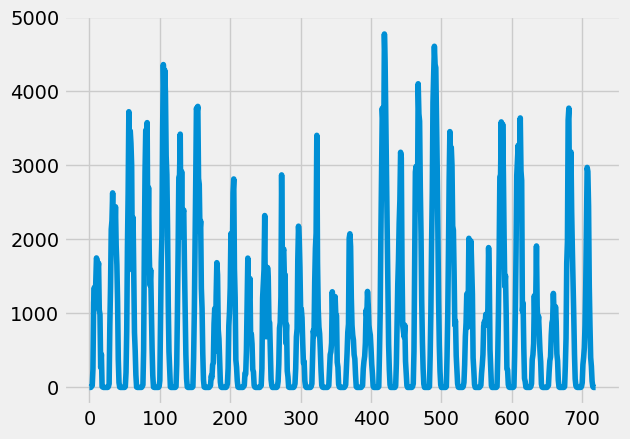

In [127]:
plt.plot(y_pred['a'])

In [128]:
# result_A = unnorm_df(result_A, means[0][1], stds[0][1])
# result_B = unnorm_df(result_B, means[1][1], stds[1][1])
# result_C = unnorm_df(result_C, means[2][1], stds[2][1])

In [129]:
test = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")
test_copy = test.copy() 

In [130]:
id = range(2160)

In [131]:
nom_fichier = 'TS_v1'
repertoire = ""
result = np.concatenate((np.concatenate((result_A,result_B)), result_C))
submission = pd.DataFrame({'id': id, 'prediction': result})

test_copy['prediction'] = result
sample_submission = sample_submission[['id']].merge(test_copy[['id', 'prediction']], on='id', how='left')
sample_submission.to_csv(repertoire+ nom_fichier+'.csv', index=False)